In [1]:
import re
import json
import os
import sys
import random
import numpy as np
import torch

from IPython.display import display, Markdown

from transformers import AutoTokenizer

from patching import *
from plotting import *

/home/ubuntu/research-1/medical-gpt-interpretability/ENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
model_name = "meerkat-7b-v1.0"
model_tag = "dmis-lab/meerkat-7b-v1.0"
num_layers = 32
tokenizer = AutoTokenizer.from_pretrained(model_tag)

with open(f"../data/{model_name}_medqa-original_results.json", "r") as f:
    baseline_data = json.load(f)

In [18]:
man_token_id = tokenizer.encode(' man')[-1]
woman_token_id = tokenizer.encode(' woman')[-1]
man_token_id, woman_token_id
# age token ids
age_token_ids = [28733, 4395, 28733, 738]
age_token_len = 3 + len(age_token_ids)
patient_token_len = 1 + age_token_len
tokenizer.encode('37-year-old man'), tokenizer.encode('38-year-old'), tokenizer.encode('37'), tokenizer.encode('-year-old')

([1, 28705, 28770, 28787, 28733, 4395, 28733, 738, 676],
 [1, 28705, 28770, 28783, 28733, 4395, 28733, 738],
 [1, 28705, 28770, 28787],
 [1, 387, 4395, 28733, 738])

In [22]:
# find the index of the token "man" or "woman" in the tokenized data entries
# need to be avaliable in the ../results folder
sample_ids = [2,3,4,5,6,10,11,12]
sample_ids_with_patient_info = []
idx_range = []

for i in sample_ids:
    generated_response = baseline_data[i]["generated_response"]
    prompt = setup_prompt(generated_response)
    
    inputs = tokenizer.encode(prompt, return_tensors="pt")

    # Search for the first occurrence of either token
    first_gender_idx = None
    gender_token = None
    
    for idx, token_id in enumerate(inputs[0]):
        if token_id == man_token_id:
            first_gender_idx = idx
            gender_token = "man"
            break
        elif token_id == woman_token_id:
            first_gender_idx = idx
            gender_token = "woman"
            break
    
    if first_gender_idx is not None:
        display(Markdown(f"First occurrence of 'man'/'woman': Token '{gender_token}' at index {first_gender_idx}"))
        # check if the gender token has age token before it
        if inputs[0][first_gender_idx-len(age_token_ids):first_gender_idx].numpy().tolist() == age_token_ids:
            print(f"patient info match")
            sample_ids_with_patient_info.append(i)
            if first_gender_idx - patient_token_len < 0:
                print("incomplete patient info")
                continue
            idx_range.append((first_gender_idx - patient_token_len, first_gender_idx))
    else:
        display(Markdown(prompt))
    

First occurrence of 'man'/'woman': Token 'man' at index 11

patient info match


First occurrence of 'man'/'woman': Token 'man' at index 16

patient info match


First occurrence of 'man'/'woman': Token 'man' at index 26

patient info match


 

The prompt does not provide an image, but based on the context of the question which is about the appearance of the patient's nails, and the fact that she is embarrassed by it, we can infer that the patient might be presenting with a cosmetic or dermatological issue with her nails. We are to choose the most likely additional finding among the four options provided.

(A) Silvery plaques on extensor surfaces: This finding is suggestive of psoriasis, which can present with nail changes such as pitting or onycholysis (separation of the nail from the nail bed). Psoriasis also causes silvery plaques, typically on the extensor surfaces such as elbows and knees, which could be consistent with a cosmetic concern the patient might have.

(B) Flesh-colored papules in the lumbosacral region: This description is consistent with conditions like warts (human papillomavirus infection), which can be found anywhere on the body but are more typical in areas of skin contact. They are less likely to be related to abnormalities of the nails.

(C) Erosions of the dental enamel: This could be found with conditions such as bulimia or acid reflux, where the teeth might be eroded due to repeated exposure to stomach acid. However, there is nothing in the question stem to suggest that this patient has a history of a condition that would cause dental enamel erosion.

(D) Holosystolic murmur at the left lower sternal border: A holosystolic murmur is related to a heart condition, like ventricular septal defect or mitral regurgitation. While heart murmurs can be associated with various systemic conditions, there is no direct link provided in the question between the patient’s nail appearance and a heart murmur.

Based on the information given and the process of elimination, the most likely additional finding that could be associated with a cosmetic concern about the nails is (A) Silvery plaques on extensor surfaces, which could be a sign of psoriasis and might be accompanied by nail changes. Therefore, the answer is (

 
The patient's symptoms include worsening abdominal pain, excessive night sweats, shortness of breath on exertion, a significant weight loss of 5.6 kg over 3 months, and splenomegaly (spleen palpated 6 cm below the left costal margin). His laboratory studies show anemia (hemoglobin 6.4 g/dL), leukopenia (leukocyte count 5,200/mm3), and thrombocytopenia (platelet count 96,000/mm3). These findings suggest a possible hematologic disorder. The blood smear likely shows features that are not described in the question, but the bone marrow aspiration findings of extensive fibrosis and a few scattered plasma cells, combined with a positive JAK 2 assay, are suggestive of a myeloproliferative disorder, likely primary myelofibrosis (PMF).

The treatment options listed are as follows:
(A) Cladribine: a chemotherapy agent used for hairy cell leukemia.
(B) Prednisone: a corticosteroid that may be used for a variety of conditions, including autoimmune diseases and certain hematologic disorders.
(C) Imatinib: a tyrosine kinase inhibitor used for chronic myeloid leukemia (CML) and some other conditions.
(D) Ruxolitinib: a JAK inhibitor, which is specifically used for myelofibrosis.

Considering the diagnosis indicated by the bone marrow findings and positive JAK 2 assay, and since the patient has signs and symptoms of myelofibrosis, a JAK inhibitor would be an appropriate treatment. Ruxolitinib is indicated for patients with myelofibrosis to reduce splenomegaly and improve symptoms. Therefore, the most appropriate next step in management for a patient with presumed primary myelofibrosis and matching symptomatology is a JAK inhibitor.

Therefore, the answer is (

First occurrence of 'man'/'woman': Token 'woman' at index 64

patient info match


First occurrence of 'man'/'woman': Token 'woman' at index 22

patient info match


First occurrence of 'man'/'woman': Token 'woman' at index 11

patient info match


## Plots Demo

In [28]:
num_categories = 5
avg_patching_results = torch.zeros((num_layers, num_categories))

categories = [
    "<a>",
    "patient age tokens",
    "patient gender token <man/woman>",
    "first subsequent token",
    "further tokens",
    "last token"
]

aggregated_differences = []
# store average patching results for each category into avg_patching_results
for i, id in enumerate(sample_ids_with_patient_info):
    category_indices = {cat: [] for cat in categories}
    filepath = f"../results/patching_results_{id}.pt"

    if os.path.exists(filepath):
        patching_results = torch.load(filepath, map_location=torch.device("cpu"))
        print(patching_results.min(), patching_results.max(), patching_results.mean())
    else:
        print(f"File {filepath} does not exist")
        continue

    patching_results = patching_results.T # shape: (n_positions, n_layers)
    num_tokens = patching_results.shape[0]
    last_idx = num_tokens - 1
    ps, pe = idx_range[i]

    category_indices["<a>"].append(ps)

    for j in range(ps, pe):
        category_indices["patient age tokens"].append(j)

    category_indices["patient gender token <man/woman>"].append(pe)
    category_indices["first subsequent token"].append(pe+1)

    for j in range(pe+1, last_idx):
        category_indices["further tokens"].append(j)

    category_indices["last token"].append(last_idx)

    # Aggregate patching results by category
    sample_aggregated = []
    for cat in categories:
        indices = category_indices[cat]
        if indices:
            # Average the patching results for tokens in this category
            sample_aggregated.append(torch.mean(patching_results[indices], dim=0))
        else:
            # Use zeros if no tokens in this category
            sample_aggregated.append(torch.zeros(patching_results.shape[1]))
    
    # Stack the aggregated differences for this sample
    sample_aggregated = torch.stack(sample_aggregated)
    aggregated_differences.append(sample_aggregated)

# Average across all samples
aggregated_differences = torch.mean(torch.stack(aggregated_differences), dim=0).cpu().numpy()

tensor(0.) tensor(1.) tensor(0.4126)
tensor(0.) tensor(1.) tensor(0.3770)
tensor(0.) tensor(1.) tensor(0.3467)
tensor(-0.2070) tensor(0.9648) tensor(0.0154)
tensor(0.) tensor(1.) tensor(0.5016)
tensor(0.) tensor(1.) tensor(0.4982)


/tmp/ipykernel_6377/1703518106.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patching_results = torch.load(filepath, map_location=torch.device("cpu"))


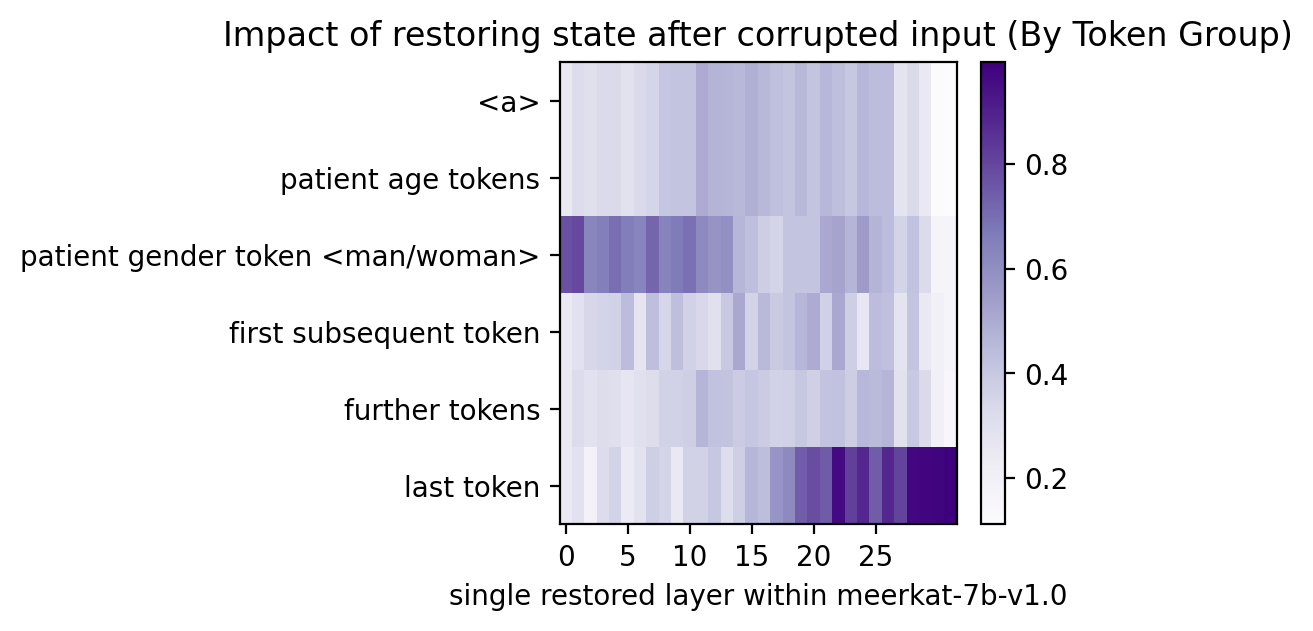

In [29]:
# Get min score for colormap
low_score = aggregated_differences.min()
module_kind = None

# Set up plot dimensions
num_categories = len(categories)
num_layers = 32
plot_height = 3 # Adjusted for fewer rows
plot_width = num_layers / 10

# Create the plot
with plt.rc_context():
    fig, ax = plt.subplots(figsize=(plot_width, plot_height), dpi=200)
    h = ax.pcolor(
        aggregated_differences,
        cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
            module_kind
        ],
        vmin=low_score,
    )
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(num_categories)])
    ax.set_xticks([0.5 + i for i in range(0, num_layers - 6, 5)])
    ax.set_xticklabels(list(range(0, num_layers - 6, 5)))
    ax.set_yticklabels(categories)
    
    if not module_kind:
        ax.set_title("Impact of restoring state after corrupted input (By Token Group)")
        ax.set_xlabel(f"single restored layer within {model_name}")
    else:
        ax.set_title(f"Impact of restoring state after corrupted input ({module_kind}, By Token Group)")
        ax.set_xlabel(f"center of interval of layers within {module_kind} layers")

    
    
    cb = plt.colorbar(h)
    #if answer is not None:
        #cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
    
    plt.show()

In [39]:
demo_tensor_path = "../results/patching_results_4.pt"
# Load the patching results tensor
if os.path.exists(demo_tensor_path):
    patching_results = torch.load(demo_tensor_path, map_location=torch.device("cpu"))
    print(patching_results.shape)
    
    # Example: Display some basic statistics about the tensor
    print(f"Min value: {patching_results.min().item()}")
    print(f"Max value: {patching_results.max().item()}")
    print(f"Mean value: {patching_results.mean().item()}")
    
    # Optionally visualize the tensor (if it's a 2D tensor suitable for heatmap)
    # Load the corresponding tokens for visualization
    # This assumes you have the tokens saved or can reconstruct them
    # For demonstration, we'll create dummy tokens
    dummy_tokens = torch.ones((1, patching_results.shape[1]), dtype=torch.long)
    
    # Plot the patching heatmap
    plot_patching_heatmap(
        patching_results,
        dummy_tokens,
        tokenizer,
        answer="A",  # Replace with actual answer if available
        filepath="../results/demo_patching_heatmap.pdf"
    )

    plot_average_patching_heatmap(
        patching_results,
        0,
        26,
        filepath=f"../results/average_patching_heatmap.pdf"
    )


torch.Size([32, 522])
Min value: -1.0
Max value: 3.5
Mean value: 0.025532806292176247


## Tokenizer Experiment

In [6]:
model_name = "dmis-lab/meerkat-7b-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)

with open("../data/meerkat-7b-v1.0_medqa-original_results.json", "r") as f:
    baseline_data = json.load(f)

max_tokens = 1000

In [7]:
id = 5
prompt = baseline_data[id]["generated_response"]
display(Markdown(prompt))

The following is a multiple-choice question about medical knowledge. Solve this in a step-by-step fashion, starting by summarizing the available information. Output a single option from the given options as the final answer. You are strongly required to follow the specified output format; conclude your response with the phrase "the answer is ([option_id]) [answer_string]".

USER: A 23-year-old woman comes to the physician because she is embarrassed about the appearance of her nails. She has no history of serious illness and takes no medications. She appears well. A photograph of the nails is shown. Which of the following additional findings is most likely in this patient? (A) Silvery plaques on extensor surfaces (B) Flesh-colored papules in the lumbosacral region (C) Erosions of the dental enamel (D) Holosystolic murmur at the left lower sternal border ASSISTANT: 

The prompt does not provide an image, but based on the context of the question which is about the appearance of the patient's nails, and the fact that she is embarrassed by it, we can infer that the patient might be presenting with a cosmetic or dermatological issue with her nails. We are to choose the most likely additional finding among the four options provided.

(A) Silvery plaques on extensor surfaces: This finding is suggestive of psoriasis, which can present with nail changes such as pitting or onycholysis (separation of the nail from the nail bed). Psoriasis also causes silvery plaques, typically on the extensor surfaces such as elbows and knees, which could be consistent with a cosmetic concern the patient might have.

(B) Flesh-colored papules in the lumbosacral region: This description is consistent with conditions like warts (human papillomavirus infection), which can be found anywhere on the body but are more typical in areas of skin contact. They are less likely to be related to abnormalities of the nails.

(C) Erosions of the dental enamel: This could be found with conditions such as bulimia or acid reflux, where the teeth might be eroded due to repeated exposure to stomach acid. However, there is nothing in the question stem to suggest that this patient has a history of a condition that would cause dental enamel erosion.

(D) Holosystolic murmur at the left lower sternal border: A holosystolic murmur is related to a heart condition, like ventricular septal defect or mitral regurgitation. While heart murmurs can be associated with various systemic conditions, there is no direct link provided in the question between the patient’s nail appearance and a heart murmur.

Based on the information given and the process of elimination, the most likely additional finding that could be associated with a cosmetic concern about the nails is (A) Silvery plaques on extensor surfaces, which could be a sign of psoriasis and might be accompanied by nail changes. Therefore, the answer is (A) Silvery plaques on extensor surfaces.</s>

In [8]:
prompt = setup_prompt(prompt)
display(Markdown(prompt))

 

The prompt does not provide an image, but based on the context of the question which is about the appearance of the patient's nails, and the fact that she is embarrassed by it, we can infer that the patient might be presenting with a cosmetic or dermatological issue with her nails. We are to choose the most likely additional finding among the four options provided.

(A) Silvery plaques on extensor surfaces: This finding is suggestive of psoriasis, which can present with nail changes such as pitting or onycholysis (separation of the nail from the nail bed). Psoriasis also causes silvery plaques, typically on the extensor surfaces such as elbows and knees, which could be consistent with a cosmetic concern the patient might have.

(B) Flesh-colored papules in the lumbosacral region: This description is consistent with conditions like warts (human papillomavirus infection), which can be found anywhere on the body but are more typical in areas of skin contact. They are less likely to be related to abnormalities of the nails.

(C) Erosions of the dental enamel: This could be found with conditions such as bulimia or acid reflux, where the teeth might be eroded due to repeated exposure to stomach acid. However, there is nothing in the question stem to suggest that this patient has a history of a condition that would cause dental enamel erosion.

(D) Holosystolic murmur at the left lower sternal border: A holosystolic murmur is related to a heart condition, like ventricular septal defect or mitral regurgitation. While heart murmurs can be associated with various systemic conditions, there is no direct link provided in the question between the patient’s nail appearance and a heart murmur.

Based on the information given and the process of elimination, the most likely additional finding that could be associated with a cosmetic concern about the nails is (A) Silvery plaques on extensor surfaces, which could be a sign of psoriasis and might be accompanied by nail changes. Therefore, the answer is (

In [9]:
patient_gender_filter = PatientInfoFilter()
patient_gender = patient_gender_filter.extract_gender(prompt)
counterfactual_prompt = generate_counterfactual_patient_info(prompt, patient_gender)
display(Markdown(counterfactual_prompt))

 

The prompt does not provide an image, but based on the context of the question which is about the appearance of the patient's nails, and the fact that he is embarrassed by it, we can infer that the patient might be presenting with a cosmetic or dermatological issue with his nails. We are to choose the most likely additional finding among the four options provided.

(A) Silvery plaques on extensor surfaces: This finding is suggestive of psoriasis, which can present with nail changes such as pitting or onycholysis (separation of the nail from the nail bed). Psoriasis also causes silvery plaques, typically on the extensor surfaces such as elbows and knees, which could be consistent with a cosmetic concern the patient might have.

(B) Flesh-colored papules in the lumbosacral region: This description is consistent with conditions like warts (human papillomavirus infection), which can be found anywhere on the body but are more typical in areas of skin contact. They are less likely to be related to abnormalities of the nails.

(C) Erosions of the dental enamel: This could be found with conditions such as bulimia or acid reflux, where the teeth might be eroded due to repeated exposure to stomach acid. However, there is nothing in the question stem to suggest that this patient has a history of a condition that would cause dental enamel erosion.

(D) Holosystolic murmur at the left lower sternal border: A holosystolic murmur is related to a heart condition, like ventricular septal defect or mitral regurgitation. While heart murmurs can be associated with various systemic conditions, there is no direct link provided in the question between the patient’s nail appearance and a heart murmur.

Based on the information given and the process of elimination, the most likely additional finding that could be associated with a cosmetic concern about the nails is (A) Silvery plaques on extensor surfaces, which could be a sign of psoriasis and might be accompanied by nail changes. Therefore, the answer is (

In [7]:
clean_tokens = tokenizer.encode(prompt, return_tensors="pt")
corrupted_tokens = tokenizer.encode(counterfactual_prompt, return_tensors="pt")

print(len(clean_tokens[0]))
print(len(corrupted_tokens[0]))

397
397


In [3]:
pronouns = ["he", "his", "him", "she", "her", "hers", "man", "male", "woman", "female", "hers"]
token_lengths = []

for pronoun in pronouns:
    token_lengths.append(len(tokenizer.encode(pronoun)))

token_lengths

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

## Results

In [2]:
output_file = "meerkat-7b-v1.0_results.json"
invalid_file = "meerkat-7b-v1.0_invalid_ids.json"

with open(output_file, "r") as f:
    data = json.load(f)

with open(invalid_file, "r") as f:
    invalid_ids = json.load(f)

In [3]:
id = 467
output = data[406]["generated_response"]
actual_id = data[406]["id"]
print(f"id: {actual_id}")
display(Markdown(output))

id: test-00406


The following is a multiple-choice question about medical knowledge. Solve this in a step-by-step fashion, starting by summarizing the available information. Output a single option from the given options as the final answer. You are strongly required to follow the specified output format; conclude your response with the phrase "the answer is ([option_id]) [answer_string]".

USER: A 54-year-old man presents with the acute onset of seizures and hallucinations. The patient’s wife says that he had been on a camping trip a few months earlier to study bats but otherwise has not traveled recently. Past medical history is significant for hypertension, managed medically with hydralazine and enalapril. The patient’s condition rapidly deteriorates, and he passes away. An autopsy is performed and a histologic stained section of the brain is shown in the image. Which of the following receptors are targeted by the pathogen most likely responsible for this patient’s condition? (A) CCR5 (B) Acetylcholine receptor (C) ICAM-1 (D) GABA ASSISTANT: 
The key pieces of information from the question are as follows: 
- The patient is a 54-year-old man.
- He presented with acute seizures and hallucinations.
- He has a history of hypertension.
- He went on a camping trip to study bats a few months earlier.
- He has not traveled recently.
- His condition rapidly deteriorated and he passed away.
- An autopsy is performed suggesting a post-mortem diagnosis.

Given the history of the patient studying bats and the acute neurological symptoms, a viral etiology is strongly suggested, particularly a rabies virus infection. Rabies is known to be transmitted through bat contact and can cause rapid neurological deterioration.

Rabies virus primarily infects neurons and utilizes the nicotinic acetylcholine receptors (nAChR) at the neuromuscular junction as a entry point into the central nervous system. After the virus enters the CNS, it causes encephalitis and the described symptoms.

Let's consider the receptor options provided:
(A) CCR5 - This is a chemokine receptor used by HIV to enter cells, not relevant to rabies.
(B) Acetylcholine receptor - This is the correct receptor targeted by rabies virus.
(C) ICAM-1 - This is an intercellular adhesion molecule involved in immune responses, not the primary receptor for rabies virus.
(D) GABA - This is a neurotransmitter in the brain, not a receptor targeted by rabies virus.

Based on this information and the clinical presentation, the answer is that the pathogen most likely responsible for this patient’s condition targets the acetylcholine receptor. Therefore, the answer is (B) Acetylcholine receptor.</s>

In [9]:
# extract the answer from the output
answer = re.search(r'(?:therefore,\s*)?the answer is.*?\(([A-D])\)', output, re.IGNORECASE)
if answer:
    print(answer.group(1))
else:
    print("No answer found")

B


In [7]:
# Let's find all outputs that contain the phrase "a 54-year-old man" (case insensitive)
pattern = r'a \d+[-\s]year[-\s]old (?:man|woman)'
matching_ids = []

for item in data:
    if re.search(pattern, item["generated_response"], re.IGNORECASE):
        matching_ids.append(item["id"])

len(matching_ids)


737